In [1]:
import sys
ws = r'C:\Users\Mel.Meng\Documents\GitHub\hhnote\hydraulics\forcemain'
sys.path.append(ws)
from friction import *
from icm import *
import os

# ICM Force Main Friction Loss Check

The link results table were copied into an excel workbook for each analysis below.

In ICM, the HW method actually is the manning's n equation. So the C factor needs to be converted to manning's n first, then apply the manning's n equation.

In [27]:
# load the results from the exported csv file
f = os.path.join(ws, 'model/data.xlsx')

fm = pd.read_excel(f, 'HW')
fm.index = pd.to_datetime(fm['datetime'])
g = pd.read_excel(f, 'gravity')
g.index = pd.to_datetime(g['datetime'])
cb = pd.read_excel(f, 'CB')
cb.index = pd.to_datetime(fm['datetime'])
pr = pd.read_excel(f, 'PR')
pr.index = pd.to_datetime(fm['datetime'])

xp = pd.read_excel(f, 'XP')
xp.index = pd.to_datetime(xp['datetime'])

xppump = pd.read_excel(f, 'XP-PUMP')
xppump.index = pd.to_datetime(xp['datetime'])

In [4]:
def get_eq_n(c, d, s0):
    return 1.067*(d/s0)**0.04/c
# setup the calculation for the dw friction loss
r = 0.5 #ft
h = 0.25 #ft
e = 0.01 #ft
v = 9 # fps

def dw_sf2(r, h, e, v):
    hrad = get_r(r, h)
    re = get_re(hrad, v)
    f = get_fricfactor(e, hrad, re)
    h = dw_sf(f, v, hrad)
    return h
print(dw_sf2(r, h, e, v))


0.09855796105083944


Text(0.5, 1.0, 'HW Comparison')

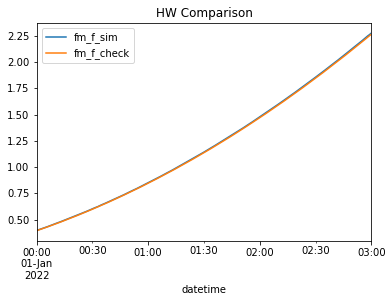

In [5]:
# calculate the friction loss for simulated, and derive the ones from velocity and depth
# model parameters
l = 100 #ft length

c = 120 # hw c factor

q = 0 # cfs flow
d = 1 # ft diameter
dz = 11 # force main z difference ft
# get the full pipe R
V, R = full_pipe_vr(q, d)
n = get_eq_n(c, d, dz/l)

fm['fm_f_sim'] = fm['US total head (ft AD)'] - fm['DS total head (ft AD)']
fm['fm_depth_change'] = fm['US depth (ft)'] - fm['DS depth (ft)'] - dz
fm['fm_f_check'] = fm.apply(lambda x: l*manning_sf(n, R, x['US velocity (ft/s)']), axis=1)
ax = fm.loc[:, ['fm_f_sim', 'fm_f_check']].plot()
ax.set_title('HW Comparison')



Text(0.5, 1.0, 'Gravity Comparison')

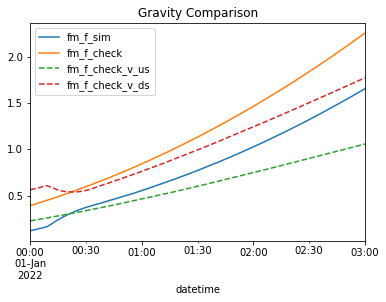

In [6]:
#gravity
n = 0.0097
g['fm_f_sim'] = g['US total head (ft AD)'] - g['DS total head (ft AD)']
# calculate the velocity from the Q instead since full uses a p slot
g['fm_f_check'] = g.apply(lambda x: l*manning_sf(n, R, full_pipe_vr(x['DS flow (ft3/s)'], d)[0]), axis=1)
g['fm_f_check_v_us'] = g.apply(lambda x: l*manning_sf(n, R, x['US velocity (ft/s)']), axis=1)
g['fm_f_check_v_ds'] = g.apply(lambda x: l*manning_sf(n, R, x['DS velocity (ft/s)']), axis=1)
ax = g.loc[:, ['fm_f_sim', 'fm_f_check']].plot()
g.loc[:, ['fm_f_check_v_us', 'fm_f_check_v_ds']].plot(ax=ax, linestyle='--')
ax.set_title('Gravity Comparison')

Text(0.5, 1.0, 'CW Comparison')

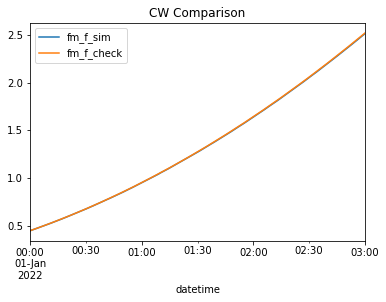

In [7]:
e = 0.01/12 #ft roughness height
cb['fm_f_sim'] = cb['US total head (ft AD)'] - cb['DS total head (ft AD)']
cb['fm_f_check'] = cb.apply(lambda x: l*dw_sf2(d/2.0, d, e, x['US velocity (ft/s)']), axis=1)

ax = cb.loc[:, ['fm_f_sim', 'fm_f_check']].plot()
ax.set_title('CW Comparison')

Text(0.5, 1.0, 'Pressure solution with two pipe segments')

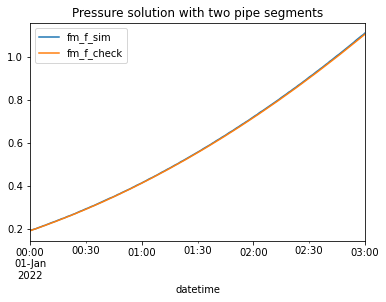

In [9]:
# using pressure solution
n = 0.0097
l = 48.9 #ft
pr['fm_f_sim'] = pr['US total head (ft AD)'] - pr['DS total head (ft AD)']
pr['fm_depth_change'] = pr['US depth (ft)'] - pr['DS depth (ft)'] - dz
pr['fm_f_check'] = pr.apply(lambda x: l*manning_sf(n, R, x['US velocity (ft/s)']), axis=1)
ax = pr.loc[:, ['fm_f_sim', 'fm_f_check']].plot()
ax.set_title('Pressure solution with two pipe segments')

(0.0, 4.0)

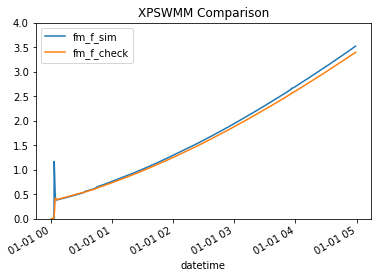

In [23]:
# calculate the friction loss for simulated, and derive the ones from velocity and depth
# model parameters
l = 100 #ft length

c = 120 # hw c factor

q = 0 # cfs flow
d = 1 # ft diameter
dz = 11 # force main z difference ft
# get the full pipe R
V, R = full_pipe_vr(q, d)
n = get_eq_n(c, d, dz/l)

xp['fm_f_sim'] = xp['US_DEPTH'] - xp['DS_DEPTH']
xp['fm_f_check'] = xp.apply(lambda x: l*manning_sf(n, R, x['VEL']), axis=1)
ax = xp.loc[:, ['fm_f_sim', 'fm_f_check']].plot()
ax.set_title('XPSWMM Comparison')
ax.set_ylim(0, 4)

In [38]:
pump_curve = [(0,0,0), (2, 12,11.825), (4,14,13.299), (6,14,12.422), (8,14,11.195), (15, 20,10.139)]
columns = ['Flow(cfs)', 'Ori. head(ft)', 'Friction Loss(ft)','check', 'FM(ft)']
n = 0.0097

data = []
for q, h, hfm in pump_curve:
    V, R = full_pipe_vr(q, d)
    sf = manning_sf(n, R, V)
    hl = sf*l
    
    data.append([q, h, hl, h-hl, hfm])


results = pd.DataFrame(data, columns=columns)

In [39]:
print(results)

   Flow(cfs)  Ori. head(ft)  Friction Loss(ft)      check  FM(ft)
0          0              0           0.000000   0.000000   0.000
1          2             12           0.174501  11.825499  11.825
2          4             14           0.698004  13.301996  13.299
3          6             14           1.570509  12.429491  12.422
4          8             14           2.792015  11.207985  11.195
5         15             20           9.815679  10.184321  10.139


Text(0.5, 1.0, 'XPSWMM Pump Curve Comparison')

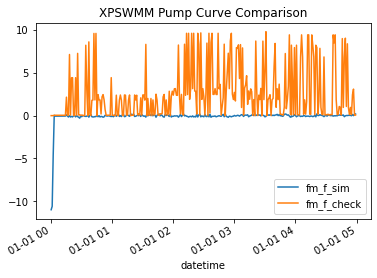

In [29]:
# calculate the friction loss for simulated, and derive the ones from velocity and depth
# model parameters
l = 100 #ft length

c = 120 # hw c factor

q = 0 # cfs flow
d = 1 # ft diameter
dz = 11 # force main z difference ft
# get the full pipe R
V, R = full_pipe_vr(q, d)
n = get_eq_n(c, d, dz/l)

xppump['fm_f_sim'] = xppump['US_DEPTH'] - xppump['DS_DEPTH']
xppump['fm_f_check'] = xppump.apply(lambda x: l*manning_sf(n, R, full_pipe_vr(x['FLOW'], d)[0]), axis=1)
ax = xppump.loc[:, ['fm_f_sim', 'fm_f_check']].plot()
ax.set_title('XPSWMM Pump Curve Comparison')
# ax.set_ylim(0, 4)

<AxesSubplot:xlabel='FLOW', ylabel='fm_f_sim'>

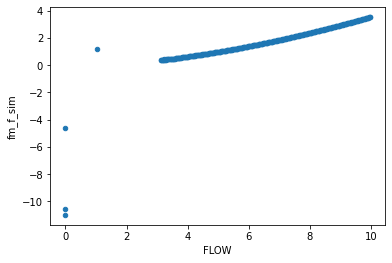

In [25]:
xp.loc[:, ['fm_f_sim', 'FLOW']].plot.scatter(x='FLOW', y='fm_f_sim')

In [26]:
xp.loc[:, ['fm_f_sim', 'FLOW']]

,fm_f_sim,FLOW
datetime,,
2022-01-01 00:00:00,-11.000,0.000
2022-01-01 00:01:00,-10.600,0.000
2022-01-01 00:02:00,-4.600,0.000
2022-01-01 00:03:00,1.169,1.018
2022-01-01 00:04:00,0.445,3.240
...,...,...
2022-01-01 04:56:00,3.479,9.895
2022-01-01 04:57:00,3.491,9.917
2022-01-01 04:58:00,3.510,9.942
